<a href="https://colab.research.google.com/github/RajeswariKumaran/SSLMethodsAnalysis/blob/main/pseudolabelling_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Baselined supervised

In [ ]:
# 1. Model: SimpleCNN (from your VAT code)
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(8*8*128, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# 2. CIFAR-10 Dataset & Data Loaders
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np

def get_cifar10_dataloaders(batch_size=128, num_labeled=4000):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    indices = np.arange(len(full_train))
    np.random.shuffle(indices)

    labeled_indices = indices[:num_labeled]
    unlabeled_indices = indices[num_labeled:]

    labeled_set = Subset(full_train, labeled_indices)
    labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return labeled_loader, test_loader

In [ ]:
labeled_loader, test_loader = get_cifar10_dataloaders()

100%|██████████| 170M/170M [00:03<00:00, 43.3MB/s]


In [ ]:
len(labeled_loader.dataset)

4000

In [ ]:
#  3. Train Function (Supervised Only)
def train_supervised(model, train_loader, test_loader, epochs=30, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss:.4f} - Train Acc: {acc:.2f}%")

    evaluate(model, test_loader, device)


In [ ]:
# 4. Evaluation Function with Metrics & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()

    acc = 100 * np.mean(y_pred == y_true)
    print(f"\n✅ Test Accuracy: {acc:.2f}%")
    print("\n📊 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=[
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ],
                yticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

In [ ]:
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
# import torch
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)  # Move model to GPU if available

# For torchsummary
summary(model, input_size=(3, 32, 32))

# OR for a manual forward pass
sample_input = torch.randn(1, 3, 32, 32).to(device)
output = model(sample_input)



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]          73,856
         MaxPool2d-6            [-1, 128, 4, 4]               0
            Linear-7                  [-1, 256]         524,544
            Linear-8                   [-1, 10]           2,570
Total params: 620,362
Trainable params: 620,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.55
Params size (MB): 2.37
Estimated Total Size (MB): 2.93
----------------------------------------------------------------


Epoch [1/30] - Loss: 67.3093 - Train Acc: 23.00%
Epoch [2/30] - Loss: 57.2654 - Train Acc: 34.83%
Epoch [3/30] - Loss: 53.4135 - Train Acc: 38.50%
Epoch [4/30] - Loss: 50.3996 - Train Acc: 41.65%
Epoch [5/30] - Loss: 49.1634 - Train Acc: 44.20%
Epoch [6/30] - Loss: 47.2744 - Train Acc: 46.20%
Epoch [7/30] - Loss: 46.5166 - Train Acc: 46.45%
Epoch [8/30] - Loss: 44.2557 - Train Acc: 48.30%
Epoch [9/30] - Loss: 44.0047 - Train Acc: 50.02%
Epoch [10/30] - Loss: 43.1211 - Train Acc: 50.83%
Epoch [11/30] - Loss: 41.2280 - Train Acc: 52.80%
Epoch [12/30] - Loss: 40.7636 - Train Acc: 53.55%
Epoch [13/30] - Loss: 40.3453 - Train Acc: 53.73%
Epoch [14/30] - Loss: 38.8918 - Train Acc: 55.35%
Epoch [15/30] - Loss: 38.1184 - Train Acc: 57.60%
Epoch [16/30] - Loss: 37.5782 - Train Acc: 57.15%
Epoch [17/30] - Loss: 36.5954 - Train Acc: 57.62%
Epoch [18/30] - Loss: 36.2742 - Train Acc: 58.27%
Epoch [19/30] - Loss: 35.2677 - Train Acc: 60.23%
Epoch [20/30] - Loss: 34.8525 - Train Acc: 60.88%
Epoch [21

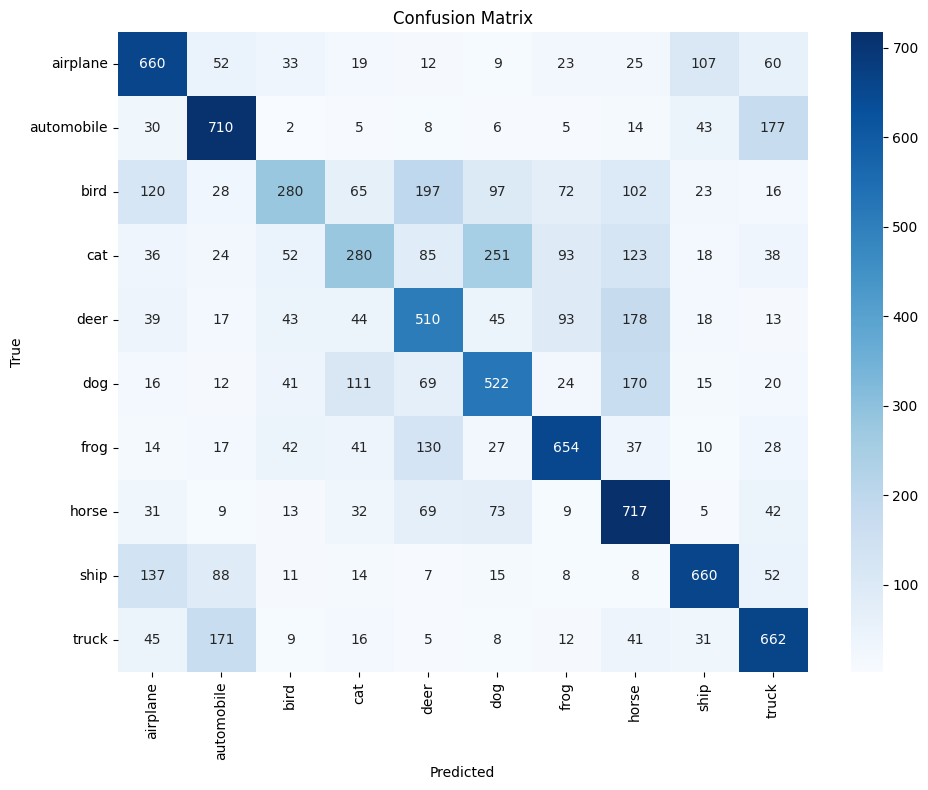

In [ ]:
# 5. Run the Whole Pipeline
# Prepare data
labeled_loader, test_loader = get_cifar10_dataloaders()

# Build model
model = SimpleCNN()

# Train supervised
train_supervised(model, labeled_loader, test_loader, epochs=30)

In [ ]:
# pseudo labelling
# What is Pseudo-Labeling?

# Pseudo-labeling is a simple semi-supervised learning approach:

# Train a model on the labeled data.
# Use that model to predict labels on the unlabeled data.
# Treat high-confidence predictions as "pseudo-labels".
# Retrain (or continue training) the model using both labeled and pseudo-labeled data.

In [ ]:
# Setup: SimpleCNN (as used earlier)
import torch
import torch.nn as nn
import torch.nn.functional as F
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 8x8
        x = self.pool(F.relu(self.conv3(x)))  # 4x4
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# Dataset Loaders with Labeled and Unlabeled Splits
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

def get_cifar10_ssl_loaders(num_labeled=4000, batch_size=128):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010))
    ])

    full_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    indices = np.arange(len(full_train))
    np.random.shuffle(indices)
    labeled_idx = indices[:num_labeled]
    unlabeled_idx = indices[num_labeled:]

    labeled_set = Subset(full_train, labeled_idx)
    unlabeled_set = Subset(full_train, unlabeled_idx)

    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    labeled_loader = DataLoader(labeled_set, batch_size=batch_size, shuffle=True, num_workers=2)
    unlabeled_loader = DataLoader(unlabeled_set, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return labeled_loader, unlabeled_loader, test_loader, unlabeled_set

In [ ]:
# Step 1: Train on Labeled Data
def train_supervised(model, loader, epochs=20, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total, correct = 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
        acc = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs} - Train Accuracy: {acc:.2f}%")

In [ ]:
# Step 2: Generate Pseudo Labels
def generate_pseudo_labels(model, unlabeled_set, threshold=0.95):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    pseudo_data = []

    with torch.no_grad():
        for i in range(len(unlabeled_set)):
            x, _ = unlabeled_set[i]
            x = x.unsqueeze(0).to(device)
            out = model(x)
            probs = F.softmax(out, dim=1)
            conf, pred = probs.max(1)
            if conf.item() >= threshold:
                pseudo_data.append((x.cpu().squeeze(), pred.item()))

    print(f"Generated {len(pseudo_data)} pseudo-labels (threshold={threshold})")
    return pseudo_data


In [ ]:
# Step 3: Create Pseudo-Labeled Dataset & Combine
from torch.utils.data import TensorDataset, ConcatDataset

def create_combined_dataset(labeled_loader, pseudo_data):
    # Extract labeled set
    labeled_dataset = labeled_loader.dataset

    if len(pseudo_data) == 0:
        return labeled_loader

    images, labels = zip(*pseudo_data)
    pseudo_dataset = TensorDataset(torch.stack(images), torch.tensor(labels))

    combined_dataset = ConcatDataset([labeled_dataset, pseudo_dataset])
    combined_loader = DataLoader(combined_dataset, batch_size=128, shuffle=True, num_workers=2)
    return combined_loader

In [ ]:
class ToTensorLabelWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.long)
        return x, y

    def __len__(self):
        return len(self.dataset)

In [ ]:
from torch.utils.data import TensorDataset, ConcatDataset, DataLoader
import torch

def create_combined_dataset(labeled_loader, pseudo_data):
    # labeled_dataset = labeled_loader.dataset
    labeled_dataset = ToTensorLabelWrapper(labeled_loader.dataset)

    if len(pseudo_data) == 0:
        return labeled_loader

    # Unzip pseudo_data and convert to tensors
    images, labels = zip(*pseudo_data)

    # Convert images to a single 4D tensor: [N, C, H, W]
    images = torch.stack(images)

    # Convert labels to a 1D tensor: [N]
    labels = torch.tensor(labels, dtype=torch.long)

    # Create pseudo dataset
    pseudo_dataset = TensorDataset(images, labels)


    # Combine datasets
    combined_dataset = ConcatDataset([labeled_dataset, pseudo_dataset])

    # Create new DataLoader
    combined_loader = DataLoader(
        combined_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=2
    )

    return combined_loader


In [ ]:
# Step 4: Retrain with Pseudo-Labels
def retrain_with_pseudo_labels(model, combined_loader, test_loader, epochs=20, lr=1e-3):
    train_supervised(model, combined_loader, epochs, lr)
    evaluate(model, test_loader)

In [ ]:
# Evaluate
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            pred = out.argmax(1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"\n✅ Final Test Accuracy: {acc:.2f}%")
    # print(classification_report(all_labels, all_preds))

    # cm = confusion_matrix(all_labels, all_preds)
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    # plt.xlabel("Predicted")
    # plt.ylabel("True")
    # plt.title("Confusion Matrix")
    # plt.show()

    # acc = 100 * np.mean(y_pred == y_true)
    # print(f"\n✅ Test Accuracy: {acc:.2f}%")
    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ],
                yticklabels=[
                    'airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'
                ])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

Epoch 1/30 - Train Accuracy: 20.50%
Epoch 2/30 - Train Accuracy: 31.15%
Epoch 3/30 - Train Accuracy: 35.85%
Epoch 4/30 - Train Accuracy: 41.73%
Epoch 5/30 - Train Accuracy: 44.08%
Epoch 6/30 - Train Accuracy: 46.33%
Epoch 7/30 - Train Accuracy: 47.08%
Epoch 8/30 - Train Accuracy: 49.35%
Epoch 9/30 - Train Accuracy: 50.85%
Epoch 10/30 - Train Accuracy: 52.80%
Epoch 11/30 - Train Accuracy: 53.17%
Epoch 12/30 - Train Accuracy: 55.62%
Epoch 13/30 - Train Accuracy: 53.33%
Epoch 14/30 - Train Accuracy: 57.88%
Epoch 15/30 - Train Accuracy: 58.42%
Epoch 16/30 - Train Accuracy: 59.85%
Epoch 17/30 - Train Accuracy: 60.62%
Epoch 18/30 - Train Accuracy: 62.58%
Epoch 19/30 - Train Accuracy: 63.50%
Epoch 20/30 - Train Accuracy: 63.25%
Epoch 21/30 - Train Accuracy: 62.77%
Epoch 22/30 - Train Accuracy: 64.80%
Epoch 23/30 - Train Accuracy: 65.12%
Epoch 24/30 - Train Accuracy: 66.60%
Epoch 25/30 - Train Accuracy: 67.97%
Epoch 26/30 - Train Accuracy: 68.58%
Epoch 27/30 - Train Accuracy: 68.97%
Epoch 28/3

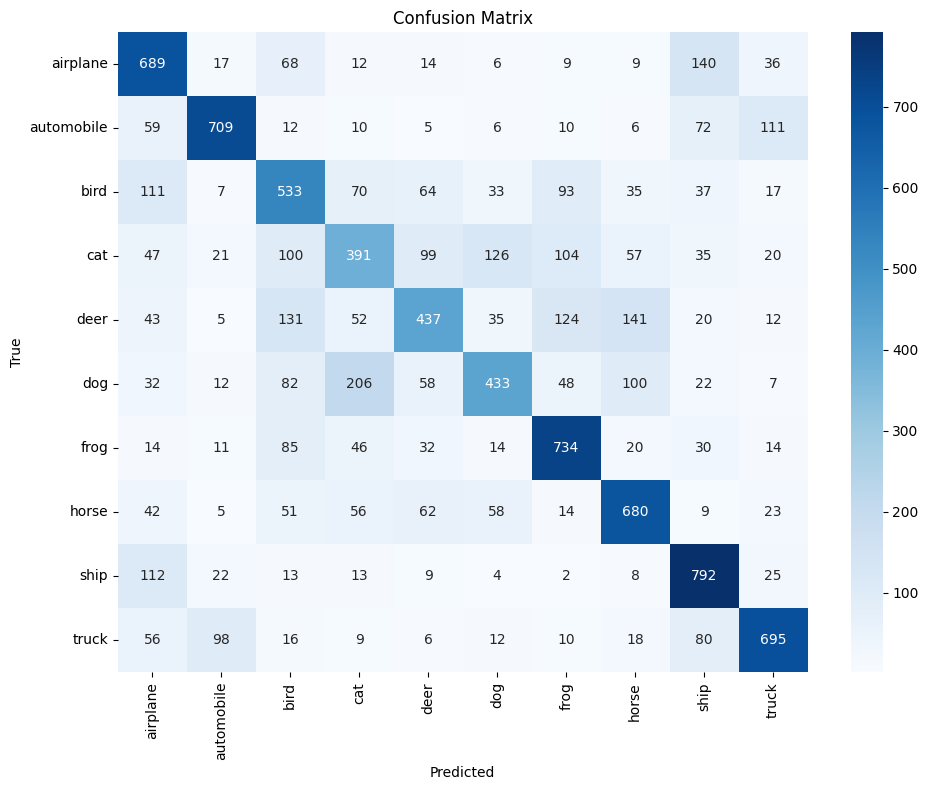

In [ ]:
# Run Full Pseudo-Labeling Pipeline
# Load data
labeled_loader, unlabeled_loader, test_loader, unlabeled_set = get_cifar10_ssl_loaders()

# Step 1: Train on labeled data
model = SimpleCNN()
train_supervised(model, labeled_loader, epochs=30)

# Step 2: Generate pseudo-labels
pseudo_data = generate_pseudo_labels(model, unlabeled_set, threshold=0.95)

# Step 3: Combine datasets
combined_loader = create_combined_dataset(labeled_loader, pseudo_data)

# Step 4: Retrain model
retrain_with_pseudo_labels(model, combined_loader, test_loader, epochs=30)

In [ ]:
len(combined_loader.dataset)

10455

In [ ]:
len(labeled_loader.dataset)

4000